# 번역기 만들기

## 개념

RNN 모듈 2개를 ENcoder- Decoder로 결합하여 사용하는 Seq2Seq의 발견.

Encoder와 Decoder 구조가 번역기에 최적화 되어있는 만큼 직접 Seq2seq 기반 번역기 만들어보기.

## 준비물
----------------

``` terminal
$ mkdir -p ~/aiffel/s2s_translation
```

한국어 폰트 
```
$ sudo apt -qq -y install fonts-nanum
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)
from konlpy.tag import Mecab


2.2.0


## Step 1. 데이터 다운로드 및 준비

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받고 압축을푼다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)


압축을 풀면 

korean-english-park.train.en          
korean-english-park.train.ko                   

두 파일이 나온다.




``` terminal
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ mv korean-english-park.train.tar.gz ~/aiffel/s2s_translation
$ cd ~/aiffel/s2s_translation && tar -xvf korean-english-park.train.tar.gz




In [3]:
path_to_folder = os.getenv('HOME') + "/aiffel/s2s_translation/"
path_to_file_en =  path_to_folder + "korean-english-park.train.en"
path_to_file_ko = path_to_folder + "korean-english-park.train.ko"

In [4]:
with open(path_to_file_ko , "r") as f:
    data_ko = f.read().splitlines()

print("Data Size:", len(data_ko))
print("Example:")

for sen in data_ko[0:100][::20]: print(">>", sen)


Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(path_to_file_en , "r") as f:
    data_en = f.read().splitlines()

print("Data Size:", len(data_en))
print("Example:")

for sen in data_en[0:100][::20]: print(">>", sen)


Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


데이터의 순서가 같은 순서로 만들어진것을 확인할 수 있다. 근데 주의해야할것이 

마지막 단락의 경우 문장의 순서가 완전히 다른것을 확인할 수 있었다.

(영어는 Researcher also debated부터 시작하는데 한국어는 연구학자들은 파트가 뒤에 있음)


## Step 2. 데이터 정제

주의 해야할점.  

1. 중복된 데이터를 제거하되 병렬된 쌍이 흐트러지지 않게 주의함.

2. 한국어에 맞는 정규식을 추가하여 전처리하기 

3. 타겟 언어인 영문은 \<star> 토큰과 \<end> x토큰 추가하고 split으로 토근화. 한글 토큰화는 KoNLPy의 mecab을 사용
    
* 모든 데이터 사용시 학습이 오래 걸리므로 토큰의 길이 40 이하의 데이터를 선별하여 구축하기

In [21]:
cleaned_corpus = set(zip(data_ko,data_en))

zip으로 묶은뒤 set을 하면 병렬된 쌍을 지키면서 중복된 데이터를 제거할 수 있다.

In [7]:
def preprocess_sentence(sentence, k_token = False, e_token = False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    if k_token:
        mecab = Mecab()
        sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
        sentence = mecab.morphs(sentence)

    if e_token:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence = '<start> ' + sentence
        sentence += ' <end>'
        sentence = sentence.split()

    return sentence

In [23]:
eng_corpus = []
kor_corpus = []


for pair in cleaned_corpus:
    pre_kor = preprocess_sentence(pair[0], k_token = True)
    pre_eng = preprocess_sentence(pair[1], e_token = True)
    
    if (len(pre_kor) <= 40) & (len(pre_eng) <= 40): # 길이 40 이하의 토큰만 corpus에 추가 
        eng_corpus.append(pre_eng)
        kor_corpus.append(pre_kor)

In [24]:
print("English:", eng_corpus[30])  
print("Korean:", kor_corpus[30]) 

English: ['<start>', 'Three', 'strong', 'earthquakes', 'struck', 'Sunday', 'near', 'New', 'Zealand', 'and', 'the', 'U', '.', 'S', '.', 'territory', 'of', 'Guam', 'in', 'remote', 'parts', 'of', 'the', 'South', 'Pacific', ',', 'monitoring', 'agencies', 'said', '.', '<end>']
Korean: ['뉴질랜드', '와', '미국', '령', '괌', '등', '남태평양', '연안', '에서', '차례', '의', '강력', '한', '지진', '이', '발생', '했', '다고', '일', '현지', '시간', '지진', '관측소', '가', '밝혔', '다', '.']


깔끔하게 이어진 문장도 있었으며

In [25]:
print("English:", eng_corpus[80])  
print("Korean:", kor_corpus[80]) 

English: ['<start>', 'While', 'people', 'their', 's', 'and', 's', 'have', 'the', 'lowest', 'accident', 'rates', 'of', 'all', 'drivers', ',', 'at', 'some', 'point', 'in', 'the', 'mid', 's', 'this', 'rate', 'starts', 'to', 'climb', 'again', ',', 'Warden', 'said', '.', '<end>']
Korean: ['와든', '부사장', '은', '대', '와', '대', '노년층', '이', '다른', '운전자', '에', '사고', '율', '이', '낮', '은', '반면', '세', '이상', '노인', '들', '의', '사고', '율', '이', '다시', '높', '아', '지', '기', '시작', '한다고', '말', '했', '다', '.']


다소 이해할게 엮여진 문장도 존재하게 되었다.

In [26]:
print(len(kor_corpus), len(eng_corpus))

63139 63139


## Step3. 데이터 토큰화

In [19]:
def tokenize(corpus, num_words = 15000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [27]:
# 토큰화하기

eng_tensor, eng_tokenizer = tokenize(eng_corpus)
kor_tensor, kor_tokenizer = tokenize(kor_corpus)

In [28]:
del eng_corpus
del kor_corpus
del cleaned_corpus

필요없어진것들은 지워준다.

In [29]:
print("English Vocab Size:", len(eng_tokenizer.index_word))
print("Korean Vocab Size:", len(kor_tokenizer.index_word))

English Vocab Size: 38540
Korean Vocab Size: 37076


In [30]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [33]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 38541)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [35]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## Step 4. 훈련하기 

In [36]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 987/987 [05:55<00:00,  2.78it/s, Loss 1.6830]


loss가 지속적으로 감소하면서 학습이 되어가는 것을 확인할 수 있었다.

In [41]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence, k_token= True)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [42]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [43]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

#### 예문 ## 
K1) 오바마는 대통령이다.     
K2) 시민들은 도시 속에 산다.       
K3) 커피는 필요 없다.    
K4) 일곱 명의 사망자가 발생했다.       

#### 제출 ##
E1) obama is the president . \<end>     
E2) people are victims of the city . \<end>    
E2) the price is not enough . \<end>      
E2) seven people have died . \<end>    

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama s president obama is the president s running mate . <end> 


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


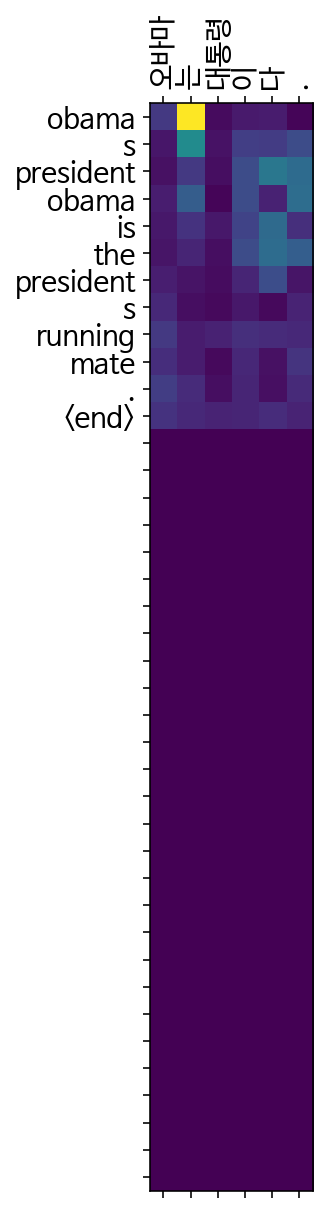

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the city s day , the city s day , the city s day , the city s day , the city s day , the city s day , the city s day , the city s day , 


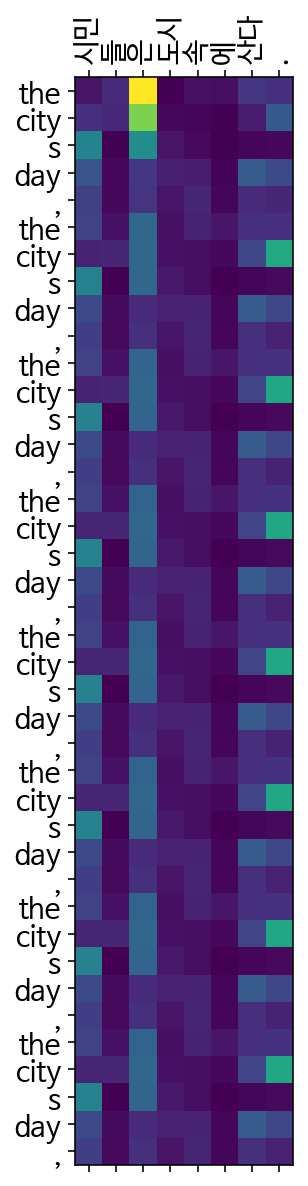

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the coffee is not a big question <end> 


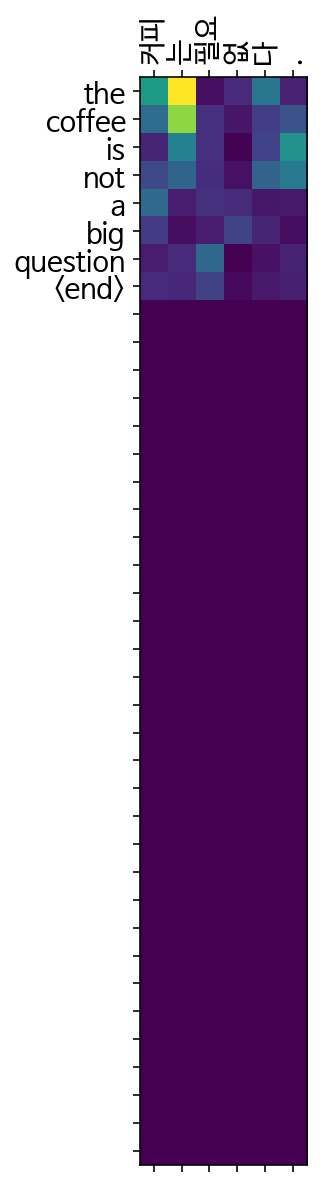

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: six people were killed . <end> 


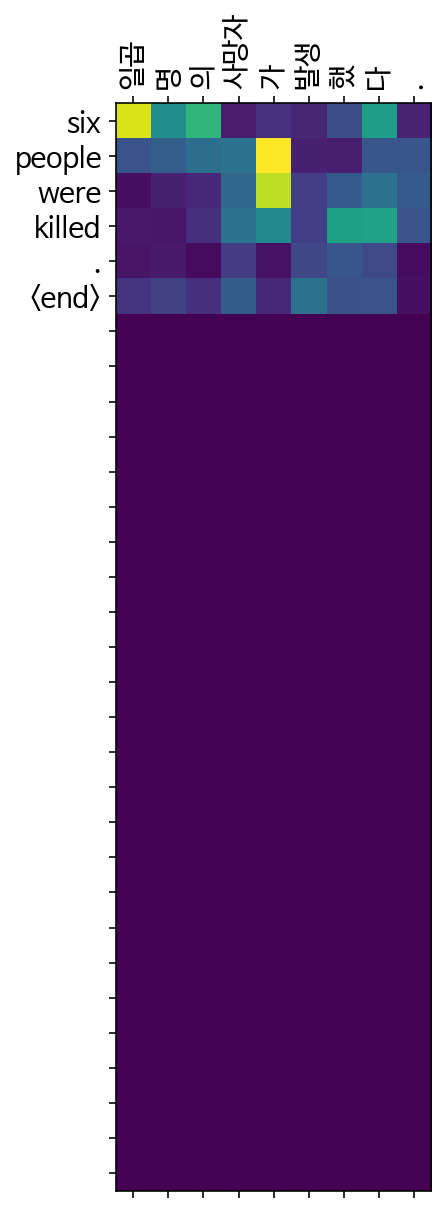

In [44]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

학습도 제대로 안되고 evaluate도 잘 안되서 힘들었었는데 결국 꽤나 괜찮은 번역도 나타나게 되었다.       
규칙기반 번역이었으면  사망자 -> the dead 이니
there was seven the dead 이런식으로 번역이 됐을꺼같은데      
영어적 표현에 맞게 six peoplle were killed라고 번역된게 **참 멋있다.**

> Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']         
> Predicted translation: six people were killed . <end> 

## 소고

솔직히 너무 어려웠다.. 처음에 하다가 잘못 코드를 쳐서 

번역이 안되서 모든 번역문이 the the the the the the the 이런식으로 나왔는데 

공포영화인줄 알았다.

모델이 복잡해서 잘 이해가 되지 않았따.. 

그래도 마지막 일곱명의 사망자가 발생했다는 꽤나 멋있게 번역되서 만족스럽다.

# 루브릭

|평가문항|상세기준|
|:-|:-|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|